In [1]:
# Cell 1: Install Required Dependencies
# Run this first to install all necessary packages
# !pip install torch torchvision transformers
# !pip install PyMuPDF opencv-python pillow pandas numpy
# !pip install paddlepaddle paddleocr
# !pip install openpyxl matplotlib seaborn  


In [1]:
# Cell 2: Import Libraries and Define the Extractor Class
import os
import cv2
import numpy as np
import pandas as pd
import json
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import fitz  # PyMuPDF
from PIL import Image, ImageEnhance, ImageFilter
import torch
from transformers import DetrImageProcessor, TableTransformerForObjectDetection
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class PDFTableExtractor:
    """
    A comprehensive pipeline for extracting tables from scanned PDF documents.
    """
    
    def __init__(self, 
                 ocr_lang='en',
                 table_model_name="microsoft/table-transformer-detection",
                 output_dir="extracted_tables"):
        """
        Initialize the PDF Table Extractor.
        
        Args:
            ocr_lang: Language for OCR (default: 'en')
            table_model_name: Hugging Face model name for table detection
            output_dir: Directory to save extracted tables
        """
        self.ocr_lang = ocr_lang
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
        # Initialize OCR
        print("Initializing OCR...")
        self.ocr = PaddleOCR(use_angle_cls=True, lang=ocr_lang)
        
        # Initialize table detection model
        print("Loading table detection model...")
        self.table_processor = DetrImageProcessor.from_pretrained(table_model_name)
        self.table_model = TableTransformerForObjectDetection.from_pretrained(table_model_name)
        
        print("Pipeline initialized successfully!")
    
    def pdf_to_images(self, pdf_path: str, dpi: int = 300) -> List[np.ndarray]:
        """Convert PDF pages to images."""
        print(f"Converting PDF to images: {pdf_path}")
        images = []
        
        try:
            pdf_document = fitz.open(pdf_path)
            
            for page_num in range(len(pdf_document)):
                page = pdf_document.load_page(page_num)
                
                # Convert to image
                mat = fitz.Matrix(dpi/72, dpi/72)
                pix = page.get_pixmap(matrix=mat)
                img_data = pix.tobytes("png")
                
                # Convert to numpy array
                nparr = np.frombuffer(img_data, np.uint8)
                img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                images.append(img)
                
                print(f"Converted page {page_num + 1}/{len(pdf_document)}")
            
            pdf_document.close()
            
        except Exception as e:
            print(f"Error converting PDF to images: {str(e)}")
            
        return images
    
    def preprocess_image(self, image: np.ndarray) -> np.ndarray:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        binary = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 25, 15
        )
        processed_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
        return processed_img

    def detect_tables(self, image: np.ndarray, confidence_threshold: float = 0.7) -> List[Dict]:
        """
        Detect tables in the image using Table Transformer with enhanced filtering.
        """
        # Convert BGR to RGB for the model
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_image)
        
        # Prepare inputs
        inputs = self.table_processor(images=pil_image, return_tensors="pt")
        
        # Run inference
        with torch.no_grad():
            outputs = self.table_model(**inputs)
        
        # Process outputs
        target_sizes = torch.tensor([pil_image.size[::-1]])
        results = self.table_processor.post_process_object_detection(
            outputs, threshold=confidence_threshold, target_sizes=target_sizes
        )[0]
        
        # Initial table detections
        raw_tables = []
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            if score > confidence_threshold:
                x1, y1, x2, y2 = box.tolist()
                raw_tables.append({
                    'bbox': [int(x1), int(y1), int(x2), int(y2)],
                    'confidence': float(score),
                    'label': int(label)
                })
        
        print(f"Raw detections: {len(raw_tables)} tables")
        
        # Apply filtering to remove false positives
        filtered_tables = self.filter_table_detections(image, raw_tables)
        
        print(f"After filtering: {len(filtered_tables)} tables")
        return filtered_tables
   
    def crop_table_regions(self, image: np.ndarray, tables: List[Dict]) -> List[np.ndarray]:
        """
        Crop table regions from the image with improved bounding box refinement.
        
        Args:
            image: Input image
            tables: List of table detection results
            
        Returns:
            List of cropped table images with refined boundaries
        """
        cropped_tables = []
        
        for i, table in enumerate(tables):
            x1, y1, x2, y2 = table['bbox']
            
            print(f"Original bbox for table {i+1}: ({x1}, {y1}, {x2}, {y2})")
            
            # Extract the region of interest
            roi = image[y1:y2, x1:x2]
            
            if roi.size == 0:
                print(f"Warning: Empty ROI for table {i+1}, skipping refinement")
                # Fallback to original bbox with minimal padding
                padding = 5
                x1_final = max(0, x1 - padding)
                y1_final = max(0, y1 - padding)
                x2_final = min(image.shape[1], x2 + padding)
                y2_final = min(image.shape[0], y2 + padding)
                cropped = image[y1_final:y2_final, x1_final:x2_final]
                cropped_tables.append(cropped)
                continue
            
            # Convert ROI to grayscale for analysis
            gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            
            try:
                # Method 1: Find horizontal lines (table borders/rows)
                horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
                horizontal_lines = cv2.morphologyEx(gray_roi, cv2.MORPH_OPEN, horizontal_kernel)
                
                # Method 2: Find vertical lines (table borders/columns)
                vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
                vertical_lines = cv2.morphologyEx(gray_roi, cv2.MORPH_OPEN, vertical_kernel)
                
                # Combine horizontal and vertical lines
                table_structure = cv2.addWeighted(horizontal_lines, 0.5, vertical_lines, 0.5, 0.0)
                
                # Find contours of the table structure
                contours, _ = cv2.findContours(table_structure, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                if contours:
                    # Find the largest contour (main table)
                    largest_contour = max(contours, key=cv2.contourArea)
                    x_cont, y_cont, w_cont, h_cont = cv2.boundingRect(largest_contour)
                    
                    # Calculate refined boundaries
                    top_offset = max(0, y_cont - 10)
                    bottom_offset = min(roi.shape[0], y_cont + h_cont + 10)
                    left_offset = max(0, x_cont - 10)
                    right_offset = min(roi.shape[1], x_cont + w_cont + 10)
                    
                    # Convert back to original image coordinates
                    y1_refined = y1 + top_offset
                    y2_refined = y1 + bottom_offset
                    x1_refined = x1 + left_offset
                    x2_refined = x1 + right_offset
                    
                    # But add validation to ensure minimum height
                    min_height = 200  # Minimum table height
                    if (y2_refined - y1_refined) < min_height:
                        print(f"Table {i+1} height too small ({y2_refined - y1_refined}px), using original height")
                        y2_refined = y2  # Use original bottom coordinate
                    
                    print(f"Refined bbox for table {i+1}: ({x1_refined}, {y1_refined}, {x2_refined}, {y2_refined})")
                    
                else:
                    # Fallback: Use text-based refinement
                    print(f"No table structure found for table {i+1}, using text-based refinement")
                    
                    # Apply threshold to find text regions
                    _, binary_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                    
                    # Find text regions
                    coords = np.column_stack(np.where(binary_roi > 0))
                    
                    if len(coords) > 0:
                        # Find the bounding box of all text
                        top_text = max(0, np.min(coords[:, 0]) - 15)
                        bottom_text = min(roi.shape[0], np.max(coords[:, 0]) + 15)
                        left_text = max(0, np.min(coords[:, 1]) - 15)
                        right_text = min(roi.shape[1], np.max(coords[:, 1]) + 15)
                        
                        # Convert back to original image coordinates
                        y1_refined = y1 + top_text
                        y2_refined = y1 + bottom_text
                        x1_refined = x1 + left_text
                        x2_refined = x1 + right_text
                        
                        print(f"Text-based refined bbox for table {i+1}: ({x1_refined}, {y1_refined}, {x2_refined}, {y2_refined})")
                    else:
                        # Last fallback: use original bbox with reduced padding
                        print(f"No text found for table {i+1}, using original bbox")
                        y1_refined, y2_refined = y1, y2
                        x1_refined, x2_refined = x1, x2
                
            except Exception as e:
                print(f"Error in bbox refinement for table {i+1}: {str(e)}")
                # Use original coordinates
                y1_refined, y2_refined = y1, y2
                x1_refined, x2_refined = x1, x2
            
            # Apply final padding and boundary checks
            padding = 5
            x1_final = max(0, x1_refined - padding)
            y1_final = max(0, y1_refined - padding)
            x2_final = min(image.shape[1], x2_refined + padding)
            y2_final = min(image.shape[0], y2_refined + padding)
            
            # Ensure the refined bbox is valid
            if x2_final <= x1_final or y2_final <= y1_final:
                print(f"Invalid refined bbox for table {i+1}, using original with padding")
                x1_final = max(0, x1 - padding)
                y1_final = max(0, y1 - padding)
                x2_final = min(image.shape[1], x2 + padding)
                y2_final = min(image.shape[0], y2 + padding)
            
            # Crop the refined region
            cropped = image[y1_final:y2_final, x1_final:x2_final]
            
            # Validate the cropped image
            if cropped.size == 0:
                print(f"Warning: Empty cropped image for table {i+1}")
                # Create a small default crop from original bbox
                cropped = image[y1:y2, x1:x2]
            
            cropped_tables.append(cropped)
            
            print(f"Final cropped table {i+1} shape: {cropped.shape}")
            print(f"Final bbox: ({x1_final}, {y1_final}, {x2_final}, {y2_final})")
            print("-" * 40)
        
        return cropped_tables
    
    def ocr_table(self, table_image: np.ndarray) -> List[Dict]:
        """Apply OCR to extract text from table image."""
        try:
            # Convert to grayscale if needed
            if len(table_image.shape) == 3:
                gray = cv2.cvtColor(table_image, cv2.COLOR_BGR2GRAY)
            else:
                gray = table_image

            # Try direct OCR on grayscale
            results = self.ocr.ocr(gray)
            print(f"Raw OCR results: {type(results)}, Length: {len(results) if results else 'None'}")

            # Also try on original image
            if results is None or (results and len(results) == 0):
                print("Trying OCR on original color image...")
                results = self.ocr.ocr(table_image)
                print(f"Color OCR results: {type(results)}, Length: {len(results) if results else 'None'}")

            ocr_data = []
            # Robust parsing: print the actual structure if error occurs
            if not (results and isinstance(results, list) and len(results) > 0 and isinstance(results[0], list)):
                print("[DEBUG] Unexpected OCR result structure:")
                print(results)
                return []
            if len(results[0]) == 0:
                print("[DEBUG] OCR returned an empty list for results[0]")
                return []
            print(f"Processing {len(results[0])} OCR detections...")
            for line in results[0]:
                if not line or len(line) < 2:
                    print(f"[DEBUG] Skipping malformed line: {line}")
                    continue
                bbox = line[0]
                # Defensive: line[1] should be a list/tuple with at least 1 element (text), maybe 2 (confidence)
                text = line[1][0] if isinstance(line[1], (list, tuple)) and len(line[1]) > 0 else ""
                confidence = line[1][1] if isinstance(line[1], (list, tuple)) and len(line[1]) > 1 else 0.0
                if text.strip():  # Only add non-empty text
                    x_coords = [point[0] for point in bbox]
                    y_coords = [point[1] for point in bbox]
                    ocr_data.append({
                        'text': text.strip(),
                        'bbox': [min(x_coords), min(y_coords), max(x_coords), max(y_coords)],
                        'confidence': confidence
                    })
                    print(f"Found text: '{text.strip()}' (confidence: {confidence:.2f})")
            print(f"OCR extracted {len(ocr_data)} text elements")
            return ocr_data
        except Exception as e:
            print(f"Error in OCR processing: {str(e)}")
            import traceback
            traceback.print_exc()
            print("[DEBUG] OCR input shape:", table_image.shape)
            return []    
 
    def reconstruct_table(self, ocr_data: List[Dict], table_image: np.ndarray) -> pd.DataFrame:
        """Reconstruct table structure from OCR data."""
        if not ocr_data:
            return pd.DataFrame()
        
        # Sort OCR data by vertical position (top to bottom)
        ocr_data_sorted = sorted(ocr_data, key=lambda x: x['bbox'][1])
        
        # Group text by rows based on vertical proximity
        rows = []
        current_row = []
        current_y = ocr_data_sorted[0]['bbox'][1]
        y_threshold = 20  # Pixels threshold for same row
        
        for item in ocr_data_sorted:
            y_pos = item['bbox'][1]
            
            if abs(y_pos - current_y) <= y_threshold:
                current_row.append(item)
            else:
                if current_row:
                    # Sort current row by horizontal position (left to right)
                    current_row.sort(key=lambda x: x['bbox'][0])
                    rows.append(current_row)
                current_row = [item]
                current_y = y_pos
        
        # Add the last row
        if current_row:
            current_row.sort(key=lambda x: x['bbox'][0])
            rows.append(current_row)
        
        # Convert to DataFrame
        table_data = []
        max_cols = max(len(row) for row in rows) if rows else 0
        
        for row in rows:
            row_data = []
            for i in range(max_cols):
                if i < len(row):
                    row_data.append(row[i]['text'])
                else:
                    row_data.append('')
            table_data.append(row_data)
        
        if table_data:
            # Create DataFrame with generic column names
            columns = [f'Column_{i+1}' for i in range(max_cols)]
            df = pd.DataFrame(table_data, columns=columns)
            
            # Clean up the DataFrame
            df = df.replace('', np.nan).dropna(how='all').fillna('')
            
            return df
        
        return pd.DataFrame()
    
    def visualize_detection(self, image: np.ndarray, tables: List[Dict]) -> None:
        """Visualize detected tables on the image."""
        img_copy = image.copy()
        
        for i, table in enumerate(tables):
            x1, y1, x2, y2 = table['bbox']
            confidence = table['confidence']
            
            # Draw bounding box
            cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Add label
            label = f"Table {i+1}: {confidence:.2f}"
            cv2.putText(img_copy, label, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        # Convert BGR to RGB for matplotlib
        img_rgb = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(15, 10))
        plt.imshow(img_rgb)
        plt.title(f"Detected Tables ({len(tables)} found)")
        plt.axis('off')
        plt.show()
    
    def process_pdf_interactive(self, pdf_path: str, 
                              confidence_threshold: float = 0.7,
                              visualize: bool = True) -> Dict:
        """Interactive PDF processing for notebooks."""
        pdf_path = Path(pdf_path)
        pdf_name = pdf_path.stem
        
        print(f"Processing PDF: {pdf_path}")
        print("="*50)
        
        results = {
            'pdf_name': pdf_name,
            'total_pages': 0,
            'total_tables_detected': 0,
            'total_tables_extracted': 0,
            'tables': [],
            'dataframes': []
        }
        
        try:
            # Convert PDF to images
            images = self.pdf_to_images(str(pdf_path))
            results['total_pages'] = len(images)
            
            for page_idx, image in enumerate(images):
                print(f"\nProcessing page {page_idx + 1}...")
                
                # Preprocess image
                processed_image = self.preprocess_image(image)
                
                # Detect tables
                detected_tables = self.detect_tables(processed_image, confidence_threshold)
                results['total_tables_detected'] += len(detected_tables)
                
                if not detected_tables:
                    print(f"No tables detected on page {page_idx + 1}")
                    continue
                
                # Visualize detection if requested
                if visualize:
                    print(f"Visualizing detected tables on page {page_idx + 1}")
                    self.visualize_detection(processed_image, detected_tables)
                
                # Crop and process tables
                cropped_tables = self.crop_table_regions(processed_image, detected_tables)
                
                for table_idx, cropped_table in enumerate(cropped_tables):
                    print(f"Processing table {table_idx + 1} on page {page_idx + 1}...")
                    # Debug: Save cropped tables
                    self.debug_save_cropped_tables(cropped_tables, page_idx + 1)
                    # Apply OCR
                    ocr_data = self.ocr_table(cropped_table)
                    
                    # Reconstruct table
                    df = self.reconstruct_table(ocr_data, cropped_table)
                    
                    if not df.empty:
                        results['total_tables_extracted'] += 1
                        results['dataframes'].append(df)
                        
                        table_info = {
                            'page': page_idx + 1,
                            'table_index': table_idx + 1,
                            'rows': len(df),
                            'columns': len(df.columns),
                            'confidence': detected_tables[table_idx]['confidence']
                        }
                        results['tables'].append(table_info)
                        
                        print(f"✓ Extracted table with {len(df)} rows and {len(df.columns)} columns")
                        
                        # Display the DataFrame
                        print(f"\nTable {table_idx + 1} from Page {page_idx + 1}:")
                        print("-" * 40)
                        display(df.head())  # Show first 5 rows
                    else:
                        print(f"✗ Failed to extract table {table_idx + 1} on page {page_idx + 1}")
        
        except Exception as e:
            print(f"Error processing PDF: {str(e)}")
            results['error'] = str(e)
        
        return results

    def debug_save_cropped_tables(self, cropped_tables, page_num):
        """Save cropped tables for debugging"""
        debug_dir = Path("debug_tables")
        debug_dir.mkdir(exist_ok=True)
        
        for i, cropped in enumerate(cropped_tables):
            # Save original cropped image
            cv2.imwrite(str(debug_dir / f"page_{page_num}_table_{i+1}_cropped.png"), cropped)
            
            # Save grayscale version
            gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(str(debug_dir / f"page_{page_num}_table_{i+1}_gray.png"), gray)
            
            # Save binary version (what OCR sees)
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            cv2.imwrite(str(debug_dir / f"page_{page_num}_table_{i+1}_binary.png"), binary)
            
            print(f"Saved debug images for table {i+1}")

    def detect_tables_with_filtering(self, image: np.ndarray, confidence_threshold: float = 0.7) -> List[Dict]:
        """
        Enhanced table detection with filtering to remove false positives.
        """
        # Convert BGR to RGB for the model
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_image)
        
        # Prepare inputs
        inputs = self.table_processor(images=pil_image, return_tensors="pt")
        
        # Run inference
        with torch.no_grad():
            outputs = self.table_model(**inputs)
        
        # Process outputs
        target_sizes = torch.tensor([pil_image.size[::-1]])
        results = self.table_processor.post_process_object_detection(
            outputs, threshold=confidence_threshold, target_sizes=target_sizes
        )[0]
        
        # Initial table detections
        raw_tables = []
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            if score > confidence_threshold:
                x1, y1, x2, y2 = box.tolist()
                raw_tables.append({
                    'bbox': [int(x1), int(y1), int(x2), int(y2)],
                    'confidence': float(score),
                    'label': int(label)
                })
        
        print(f"Raw detections: {len(raw_tables)} tables")
        
        # Apply filtering
        filtered_tables = self.filter_table_detections(image, raw_tables)
        
        print(f"After filtering: {len(filtered_tables)} tables")
        return filtered_tables

    def filter_table_detections(self, image: np.ndarray, tables: List[Dict]) -> List[Dict]:
        """
        Filter out false positive table detections using multiple criteria.
        """
        if not tables:
            return tables
        
        filtered_tables = []
        image_height, image_width = image.shape[:2]
        
        for i, table in enumerate(tables):
            x1, y1, x2, y2 = table['bbox']
            width = x2 - x1
            height = y2 - y1
            area = width * height
            
            # Criterion 1: Size filtering
            min_width = 200  # Minimum table width
            min_height = 100  # Minimum table height
            max_width_ratio = 0.95  # Maximum width relative to image
            max_height_ratio = 0.9  # Maximum height relative to image
            
            if width < min_width or height < min_height:
                print(f"Table {i+1} rejected: Too small ({width}x{height})")
                continue
                
            if width > image_width * max_width_ratio or height > image_height * max_height_ratio:
                print(f"Table {i+1} rejected: Too large ({width}x{height})")
                continue
            
            # Criterion 2: Position filtering (avoid header/footer regions)
            header_threshold = 0.15  # Top 15% of image
            footer_threshold = 0.85  # Bottom 85% of image
            
            center_y = (y1 + y2) / 2
            relative_center_y = center_y / image_height
            
            if relative_center_y < header_threshold:
                print(f"Table {i+1} rejected: In header region (y={relative_center_y:.2f})")
                continue
                
            if relative_center_y > footer_threshold:
                print(f"Table {i+1} rejected: In footer region (y={relative_center_y:.2f})")
                continue
            
            # Criterion 3: Content analysis - check for table-like structure
            if not self.validate_table_content(image, table):
                print(f"Table {i+1} rejected: No table-like structure detected")
                continue
            
            # Criterion 4: Aspect ratio filtering
            aspect_ratio = width / height
            if aspect_ratio < 0.5 or aspect_ratio > 10:  # Tables are usually wider than tall
                print(f"Table {i+1} rejected: Unusual aspect ratio ({aspect_ratio:.2f})")
                continue
            
            print(f"Table {i+1} accepted: {width}x{height}, confidence={table['confidence']:.3f}")
            filtered_tables.append(table)
        
        # Additional filtering: Remove overlapping detections
        filtered_tables = self.remove_overlapping_tables(filtered_tables)
        
        return filtered_tables

    def validate_table_content(self, image: np.ndarray, table: Dict) -> bool:
        """
        Validate if the detected region actually contains table-like content.
        """
        x1, y1, x2, y2 = table['bbox']
        roi = image[y1:y2, x1:x2]
        
        if roi.size == 0:
            return False
        
        # Convert to grayscale
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        
        # Method 1: Check for horizontal lines (table rows)
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
        horizontal_lines = cv2.morphologyEx(gray, cv2.MORPH_OPEN, horizontal_kernel)
        horizontal_score = np.sum(horizontal_lines > 0) / horizontal_lines.size
        
        # Method 2: Check for vertical lines (table columns)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
        vertical_lines = cv2.morphologyEx(gray, cv2.MORPH_OPEN, vertical_kernel)
        vertical_score = np.sum(vertical_lines > 0) / vertical_lines.size
        
        # Method 3: Check text density and distribution
        try:
            # Quick OCR to check text distribution
            ocr_results = self.ocr.ocr(gray)
            if ocr_results and ocr_results[0]:
                text_elements = len(ocr_results[0])
                # Tables usually have multiple text elements
                text_density_score = min(text_elements / 20, 1.0)  # Normalize
            else:
                text_density_score = 0
        except:
            text_density_score = 0
        
        # Method 4: Check for grid-like structure using contours
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter small contours and count larger ones
        significant_contours = [c for c in contours if cv2.contourArea(c) > 100]
        contour_score = min(len(significant_contours) / 10, 1.0)  # Normalize
        
        # Combine scores
        table_score = (horizontal_score * 0.3 + 
                    vertical_score * 0.3 + 
                    text_density_score * 0.2 + 
                    contour_score * 0.2)
        
        print(f"Content validation - H:{horizontal_score:.3f}, V:{vertical_score:.3f}, "
            f"T:{text_density_score:.3f}, C:{contour_score:.3f}, Total:{table_score:.3f}")
        
        # Threshold for table-like content
        return table_score > 0.15  # Adjust this threshold as needed

    def remove_overlapping_tables(self, tables: List[Dict], overlap_threshold: float = 0.5) -> List[Dict]:
        """
        Remove overlapping table detections, keeping the one with higher confidence.
        """
        if len(tables) <= 1:
            return tables
        
        # Sort by confidence (highest first)
        tables_sorted = sorted(tables, key=lambda x: x['confidence'], reverse=True)
        
        filtered_tables = []
        
        for table in tables_sorted:
            is_overlapping = False
            
            for kept_table in filtered_tables:
                overlap_ratio = self.calculate_overlap_ratio(table['bbox'], kept_table['bbox'])
                if overlap_ratio > overlap_threshold:
                    print(f"Removing overlapping table (overlap: {overlap_ratio:.2f})")
                    is_overlapping = True
                    break
            
            if not is_overlapping:
                filtered_tables.append(table)
        
        return filtered_tables

    def calculate_overlap_ratio(self, bbox1: List[int], bbox2: List[int]) -> float:
        """
        Calculate the overlap ratio between two bounding boxes.
        """
        x1_1, y1_1, x2_1, y2_1 = bbox1
        x1_2, y1_2, x2_2, y2_2 = bbox2
        
        # Calculate intersection
        x1_i = max(x1_1, x1_2)
        y1_i = max(y1_1, y1_2)
        x2_i = min(x2_1, x2_2)
        y2_i = min(y2_1, y2_2)
        
        if x2_i <= x1_i or y2_i <= y1_i:
            return 0.0  # No overlap
        
        intersection_area = (x2_i - x1_i) * (y2_i - y1_i)
        
        # Calculate union
        area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
        area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
        union_area = area1 + area2 - intersection_area
        
        return intersection_area / union_area if union_area > 0 else 0.0

    def process_pdf_interactive_enhanced(self, pdf_path: str, 
                                    confidence_threshold: float = 0.7,
                                    visualize: bool = True,
                                    auto_adjust_confidence: bool = True) -> Dict:
        """
        Enhanced PDF processing with automatic confidence adjustment.
        """
        pdf_path = Path(pdf_path)
        pdf_name = pdf_path.stem
        
        print(f"Processing PDF: {pdf_path}")
        print("="*50)
        
        results = {
            'pdf_name': pdf_name,
            'total_pages': 0,
            'total_tables_detected': 0,
            'total_tables_extracted': 0,
            'tables': [],
            'dataframes': []
        }
        
        try:
            # Convert PDF to images
            images = self.pdf_to_images(str(pdf_path))
            results['total_pages'] = len(images)
            
            for page_idx, image in enumerate(images):
                print(f"\nProcessing page {page_idx + 1}...")
                
                # Preprocess image
                processed_image = self.preprocess_image(image)
                
                # Try different confidence thresholds if auto-adjust is enabled
                if auto_adjust_confidence:
                    detected_tables = self.detect_tables_with_auto_adjust(
                        processed_image, confidence_threshold
                    )
                else:
                    detected_tables = self.detect_tables_with_filtering(
                        processed_image, confidence_threshold
                    )
                
                results['total_tables_detected'] += len(detected_tables)
                
                if not detected_tables:
                    print(f"No tables detected on page {page_idx + 1}")
                    continue
                
                # Visualize detection if requested
                if visualize:
                    print(f"Visualizing detected tables on page {page_idx + 1}")
                    self.visualize_detection(processed_image, detected_tables)
                
                # Continue with existing processing...
                # (rest of the method remains the same)
        
        except Exception as e:
            print(f"Error processing PDF: {str(e)}")
            results['error'] = str(e)
        
        return results

    def detect_tables_with_auto_adjust(self, image: np.ndarray, 
                                    initial_confidence: float = 0.7) -> List[Dict]:
        """
        Automatically adjust confidence threshold to get reasonable number of tables.
        """
        confidence_levels = [initial_confidence, initial_confidence + 0.1, 
                            initial_confidence + 0.2, initial_confidence - 0.1]
        
        for conf in confidence_levels:
            if conf <= 0 or conf >= 1:
                continue
                
            tables = self.detect_tables_with_filtering(image, conf)
            
            # Aim for 1-3 tables per page as reasonable
            if 1 <= len(tables) <= 3:
                print(f"Using confidence threshold: {conf}")
                return tables
        
        # Fallback to highest confidence that gives at least 1 table
        for conf in sorted(confidence_levels, reverse=True):
            if conf <= 0 or conf >= 1:
                continue
            tables = self.detect_tables_with_filtering(image, conf)
            if len(tables) > 0:
                print(f"Fallback confidence threshold: {conf}")
                return tables
        
        return []

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cell 3: Initialize the Extractor
print("Initializing PDF Table Extractor...")
extractor = PDFTableExtractor(
    ocr_lang='fr',  # Change to your language if needed
    output_dir='./extracted_tables'
)

Initializing PDF Table Extractor...
Initializing OCR...


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\DZKAM\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 557.90it/s]
Creating model: ('UVDoc', None)
The model(UVDoc) is not supported to run in MKLDNN mode! Using `paddle` instead!
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\DZKAM\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 2756.99it/s]
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in C:\Users\DZKAM\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 3425.32it/s]
Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in C

Loading table detection model...


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mo

Pipeline initialized successfully!


In [3]:
# Cell 4: Upload and Process Your PDF
# Method 1: If you have a PDF file in your notebook environment
pdf_path = "./releve.pdf"  # Replace with your PDF filename

# Check if file exists
if os.path.exists(pdf_path):
    print(f"✓ Found PDF file: {pdf_path}")
else:
    print(f"✗ PDF file not found: {pdf_path}")
    print("Please upload your PDF file to the notebook environment or update the path")


✓ Found PDF file: ./releve.pdf


Processing PDF: releve.pdf
Converting PDF to images: releve.pdf
Converted page 1/3
Converted page 2/3
Converted page 3/3

Processing page 1...
Raw detections: 3 tables
Content validation - H:0.739, V:0.329, T:0.000, C:1.000, Total:0.521
Table 1 accepted: 3078x933, confidence=0.493
Content validation - H:0.753, V:0.395, T:0.000, C:1.000, Total:0.544
Table 2 accepted: 3110x1081, confidence=0.843
Content validation - H:0.856, V:0.842, T:0.000, C:1.000, Total:0.709
Table 3 rejected: Unusual aspect ratio (12.23)
Removing overlapping table (overlap: 0.85)
After filtering: 1 tables
Visualizing detected tables on page 1


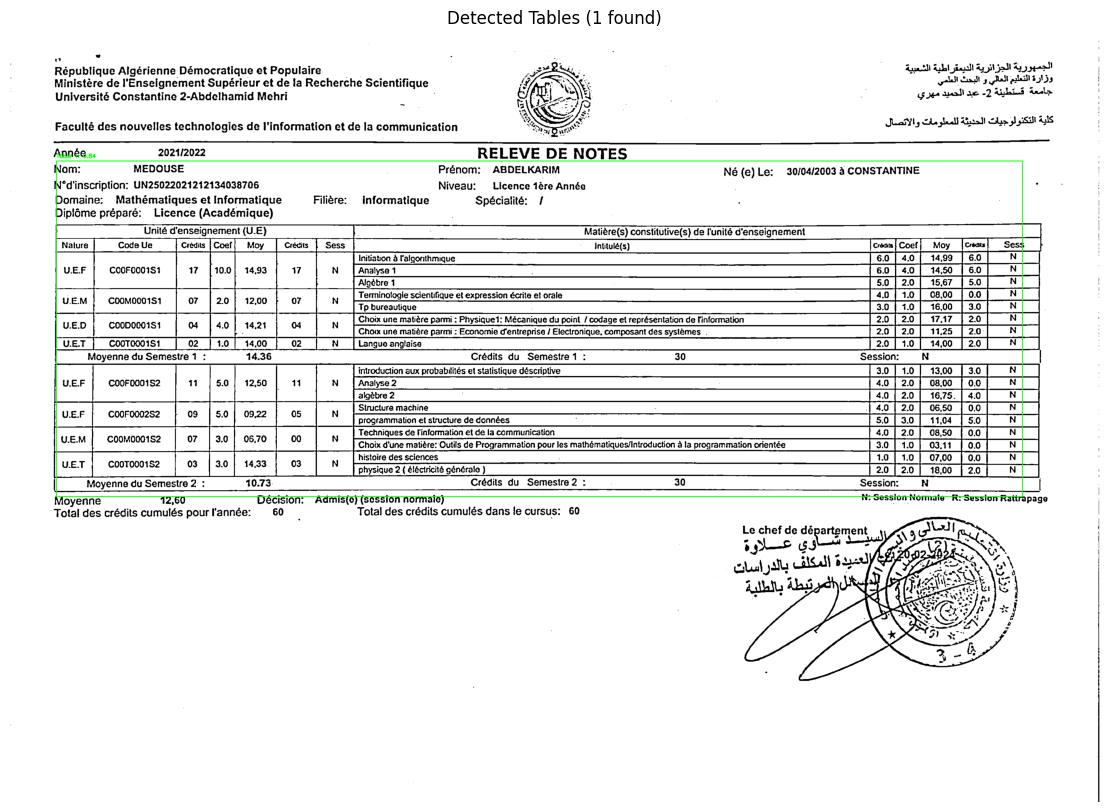

Original bbox for table 1: (149, 415, 3259, 1496)
Refined bbox for table 1: (149, 415, 3259, 635)
Final cropped table 1 shape: (230, 3120, 3)
Final bbox: (144, 410, 3264, 640)
----------------------------------------
Processing table 1 on page 1...
Saved debug images for table 1
Error in OCR processing: tuple index out of range


Traceback (most recent call last):
  File "C:\Users\DZKAM\AppData\Local\Temp\ipykernel_23500\2280483537.py", line 284, in ocr_table
    results = self.ocr.ocr(gray)
              ^^^^^^^^^^^^^^^^^^
  File "C:\Users\DZKAM\AppData\Roaming\Python\Python311\site-packages\typing_extensions.py", line 2853, in wrapper
    return arg(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\paddleocr\_pipelines\ocr.py", line 225, in ocr
    return self.predict(img, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\paddleocr\_pipelines\ocr.py", line 208, in predict
    return list(
           ^^^^^
  File "c:\Python311\Lib\site-packages\paddlex\inference\pipelines\_parallel.py", line 129, in predict
    yield from self._pipeline.predict(
  File "c:\Python311\Lib\site-packages\paddlex\inference\pipelines\ocr\pipeline.py", line 336, in predict
    doc_preprocessor_results = list(
                               ^^^^^
  File "c:\Py

[DEBUG] OCR input shape: (230, 3120, 3)
✗ Failed to extract table 1 on page 1

Processing page 2...
Raw detections: 1 tables
Content validation - H:0.834, V:0.813, T:0.000, C:1.000, Total:0.694
Table 1 rejected: Unusual aspect ratio (13.26)
After filtering: 0 tables
No tables detected on page 2

Processing page 3...
Raw detections: 0 tables
After filtering: 0 tables
No tables detected on page 3

PROCESSING SUMMARY
PDF: releve
Pages processed: 3
Tables detected: 1
Tables extracted: 0


In [4]:
# Cell 5: Process Single PDF with Visualization
if os.path.exists(pdf_path):
    # Process the PDF with interactive features
    results = extractor.process_pdf_interactive(
        pdf_path=pdf_path,
        confidence_threshold=0.3,  # Adjust threshold as needed
        visualize=True  # Set to False to skip visualization
        
    )
    
    print(f"\n{'='*50}")
    print("PROCESSING SUMMARY")
    print(f"{'='*50}")
    print(f"PDF: {results['pdf_name']}")
    print(f"Pages processed: {results['total_pages']}")
    print(f"Tables detected: {results['total_tables_detected']}")
    print(f"Tables extracted: {results['total_tables_extracted']}")
    
    if results['total_tables_extracted'] > 0:
        success_rate = (results['total_tables_extracted'] / results['total_tables_detected']) * 100
        print(f"Success rate: {success_rate:.1f}%")


In [71]:
# Cell 6: Access Individual DataFrames
if 'results' in locals() and results['dataframes']:
    print("Extracted DataFrames:")
    for i, df in enumerate(results['dataframes']):
        print(f"\nTable {i+1}:")
        print(f"Shape: {df.shape}")
        display(df)


In [72]:
# Cell 7: Save Results to Files
if 'results' in locals() and results['dataframes']:
    # Create output directory
    output_dir = Path('extracted_tables')
    output_dir.mkdir(exist_ok=True)
    
    pdf_name = results['pdf_name']
    pdf_output_dir = output_dir / pdf_name
    pdf_output_dir.mkdir(exist_ok=True)
    
    for i, df in enumerate(results['dataframes']):
        # Save as CSV
        csv_path = pdf_output_dir / f"table_{i+1}.csv"
        df.to_csv(csv_path, index=False)
        print(f"✓ Saved: {csv_path}")
        
        # Save as JSON
        json_path = pdf_output_dir / f"table_{i+1}.json"
        df.to_json(json_path, orient='records', indent=2)
        print(f"✓ Saved: {json_path}")
        
        # Save as Excel
        excel_path = pdf_output_dir / f"table_{i+1}.xlsx"
        df.to_excel(excel_path, index=False)
        print(f"✓ Saved: {excel_path}")


In [ ]:

# Cell 8: Batch Processing (Optional)
# Uncomment and modify this cell to process multiple PDFs

# pdf_directory = "pdf_documents"  # Directory containing multiple PDFs
# 
# if os.path.exists(pdf_directory):
#     pdf_files = list(Path(pdf_directory).glob("*.pdf"))
#     print(f"Found {len(pdf_files)} PDF files")
#     
#     all_results = []
#     for pdf_file in pdf_files:
#         print(f"\nProcessing: {pdf_file.name}")
#         result = extractor.process_pdf_interactive(
#             pdf_path=str(pdf_file),
#             confidence_threshold=0.6,
#             visualize=False  # Set to True if you want to see all visualizations
#         )
#         all_results.append(result)
#     
#     # Summary statistics
#     total_pdfs = len(all_results)
#     total_pages = sum(r.get('total_pages', 0) for r in all_results)
#     total_detected = sum(r.get('total_tables_detected', 0) for r in all_results)
#     total_extracted = sum(r.get('total_tables_extracted', 0) for r in all_results)
#     
#     print(f"\nBatch Processing Summary:")
#     print(f"PDFs processed: {total_pdfs}")
#     print(f"Pages processed: {total_pages}")
#     print(f"Tables detected: {total_detected}")
#     print(f"Tables extracted: {total_extracted}")
#     if total_detected > 0:
#         print(f"Overall success rate: {(total_extracted/total_detected*100):.1f}%")


In [73]:
# Cell 9: Analyze Results (Optional)
if 'results' in locals() and results['dataframes']:
    print("Data Analysis Summary:")
    print("=" * 30)
    
    for i, df in enumerate(results['dataframes']):
        print(f"\nTable {i+1} Analysis:")
        print(f"  - Shape: {df.shape}")
        print(f"  - Columns: {list(df.columns)}")
        print(f"  - Data types:")
        for col in df.columns:
            print(f"    {col}: {df[col].dtype}")
        
        # Show basic statistics for numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            print(f"  - Numeric summary:")
            display(df[numeric_cols].describe())

print("\n🎉 PDF Table Extraction Pipeline Ready!")
print("Run the cells step by step to extract tables from your PDF documents.")


🎉 PDF Table Extraction Pipeline Ready!
Run the cells step by step to extract tables from your PDF documents.
